# **EDA Assignment: Real-time Air Quality Analysis for Urban Health Monitoring**

In [ ]:
import pandas as pd
import numpy as np

# **Phase 1: Data Acquisition and Initial Cleaning**

**Load the data**

In [ ]:
df = pd.read_csv('airQualityDatas.csv')

# Data Structuring and Merging

Inspect columns

In [ ]:
print(df.columns)

Index(['location_id', 'location_name', 'parameter', 'value', 'unit',
       'datetimeUtc', 'datetimeLocal', 'timezone', 'latitude', 'longitude',
       'owner_name', 'provider'],
      dtype='object')


**Standardizing Timestamps**

Convert datetime columns to pandas datetime

In [ ]:
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'], utc=True, errors='coerce')
df['datetimeLocal'] = pd.to_datetime(df['datetimeLocal'], errors='coerce')

df = df.dropna(subset=['datetimeUtc', 'datetimeLocal'])


Single 'timestamp' column in UTC

In [ ]:
df['timestamp_utc'] = df['datetimeUtc']

Local time with timezone info

In [ ]:
df['timestamp_local'] = df['datetimeLocal'].dt.tz_convert('Asia/Kolkata')

df['timestamp_utc'] = df['datetimeLocal'].dt.tz_convert('UTC')

**Handling Location and Station Consistency**

Normalize Station Names and Coordinates

In [ ]:
df['location_name'] = df['location_name'].str.strip().str.lower()

df['latitude'] = df['latitude'].round(5)
df['longitude'] = df['longitude'].round(5)

**Pivoting Data for Multi-Pollutant, Multi-Station Structure**

Pivot so each pollutant is a column

In [ ]:
df_pivot = df.pivot_table(
    index=['location_id', 'location_name', 'timestamp_utc', 'latitude', 'longitude'],
    columns='parameter',
    values='value'
).reset_index()

In [ ]:
print(df_pivot)

parameter  location_id                  location_name  \
0                  235  anand vihar, new delhi - dpcc   
1                  235  anand vihar, new delhi - dpcc   
2                  235  anand vihar, new delhi - dpcc   
3                  235  anand vihar, new delhi - dpcc   
4                  235  anand vihar, new delhi - dpcc   
...                ...                            ...   
5409              8915         wazirpur, delhi - dpcc   
5410              8915         wazirpur, delhi - dpcc   
5411              8915         wazirpur, delhi - dpcc   
5412              8915         wazirpur, delhi - dpcc   
5413              8915         wazirpur, delhi - dpcc   

parameter             timestamp_utc  latitude  longitude    co     no    no2  \
0         2025-05-15 00:15:00+00:00  28.64684   77.31603  0.00  240.5   82.3   
1         2025-05-15 00:30:00+00:00  28.64684   77.31603  0.00  175.8   97.8   
2         2025-05-15 00:45:00+00:00  28.64684   77.31603  0.00  171.9  100.

# Initial Data Cleaning

Identify and Handle Missing Values (NaNs)

Detection

In [ ]:
missing_summary = df.isna().sum()
print("Missing values per column:\n", missing_summary)

Missing values per column:
 location_id        0
location_name      0
parameter          0
value              0
unit               0
datetimeUtc        0
datetimeLocal      0
timezone           0
latitude           0
longitude          0
owner_name         0
provider           0
timestamp_utc      0
timestamp_local    0
dtype: int64


Imputation Strategy

*Forward fill, then backward fill as a backup for remaining NaNs*

In [ ]:
df['value'] = df['value'].ffill().bfill()

Still missing, use interpolation (for numeric columns)

In [ ]:
df['value'] = df['value'].interpolate(method='linear')

Drop rows if critical columns are missing

In [ ]:
df = df.dropna(subset=['location_id', 'parameter', 'datetimeUtc'])

Flag and Address Erroneous Data

Negative values for pollutants are not physically possible

Negative or Implausible Values

In [ ]:
erroneous = df[df['value'] < 0]
print("Erroneous negative values:\n", erroneous)

Erroneous negative values:
 Empty DataFrame
Columns: [location_id, location_name, parameter, value, unit, datetimeUtc, datetimeLocal, timezone, latitude, longitude, owner_name, provider, timestamp_utc, timestamp_local]
Index: []


Set negative values to NaN

In [ ]:
df.loc[df['value'] < 0, 'value'] = np.nan

Extreme Outliers

In [ ]:
def plausible_range(row):
    if row['parameter'].lower() == 'co' and row['unit'].lower() == 'ppb':
        return 0 <= row['value'] <= 10000

    return True

df['is_plausible'] = df.apply(plausible_range, axis=1)
outliers = df[~df['is_plausible']]
print("Outliers:\n", outliers)

Outliers:
 Empty DataFrame
Columns: [location_id, location_name, parameter, value, unit, datetimeUtc, datetimeLocal, timezone, latitude, longitude, owner_name, provider, timestamp_utc, timestamp_local, is_plausible]
Index: []


Set implausible values to NaN

In [ ]:
df.loc[~df['is_plausible'], 'value'] = np.nan

**Standardize Units Across Stations**



Detect Unit Variations

In [ ]:
print(df[['parameter', 'unit']].drop_duplicates())

             parameter   unit
0                   co    ppb
1000                no    ppb
2000               no2    ppb
3000                o3  µg/m³
3988              pm10  µg/m³
4988              pm25  µg/m³
5988  relativehumidity      %
6988               so2    ppb
7988       temperature      c


**Standardization Example**


Suppose some stations report CO in mg/m³ and others in ppb.
	•	1 mg/m³ CO ≈ 870 ppb (at 25°C, 1 atm)

In [ ]:
def standardize_units(row):
    if row['parameter'].lower() == 'co':
        if row['unit'].lower() == 'mg/m3':
            return row['value'] * 870
        else:
            return row['value']

    return row['value']

df['value_ppb'] = df.apply(standardize_units, axis=1)
df['unit'] = df.apply(lambda x: 'ppb' if x['parameter'].lower() == 'co' else x['unit'], axis=1)


**Detect Sensor Malfunction (Constant or Zero Readings)**


Flagging Long Runs of Constant/Zero Values

For each station and parameter, flag if value is constant or zero for >N consecutive readings

In [ ]:
N = 6
# e.g., 6 readings = 1.5 hours if data is every 15 min

df['is_zero'] = df['value'] == 0

Group by station/parameter, then rolling sum

In [ ]:
df['zero_run'] = df.groupby(['location_id', 'parameter'])['is_zero'].transform(lambda x: x.rolling(N, min_periods=1).sum())

Flag rows where long zero run detected

In [ ]:
df['possible_sensor_fault'] = df['zero_run'] >= N

Similarly, flag constant value runs

In [ ]:
N = 6

def is_constant(x):
    return x.nunique() == 1

# Use transform to get a Series aligned with the original DataFrame
df['constant_run'] = (
    df.groupby(['location_id', 'parameter'])['value']
      .transform(lambda x: x.rolling(N, min_periods=1).apply(is_constant, raw=False))
)

df['possible_constant_fault'] = df['constant_run'] >= 1

# **Phase 2: Exploratory Data Analysis & Visualization**

**Univariate Analysis**

Descriptive Statistics for Each Pollutant

In [ ]:
from scipy.stats import skew, kurtosis, mode

In [ ]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

key_pollutants = ['pm25', 'pm10', 'o3', 'no2', 'co']

for pollutant in key_pollutants:
    data = df[df['parameter'].str.lower() == pollutant]['value'].dropna()
    if data.empty:
        print(f"\nNo data for {pollutant.upper()}")
        continue
    print(f"\n--- {pollutant.upper()} ---")
    print(f"Count: {data.count()}")
    print(f"Mean: {data.mean():.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Mode: {mode(data, keepdims=False).mode if not data.empty else 'N/A'}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")
    print(f"Std Dev: {data.std():.2f}")
    print(f"Q1: {data.quantile(0.25):.2f}")
    print(f"Q3: {data.quantile(0.75):.2f}")
    print(f"Skewness: {skew(data):.2f}")
    print(f"Kurtosis: {kurtosis(data):.2f}")


--- PM25 ---
Count: 4985
Mean: 74.38
Median: 66.00
Mode: 59.0
Min: 3.00
Max: 467.00
Std Dev: 48.99
Q1: 48.00
Q3: 86.00
Skewness: 3.62
Kurtosis: 19.15

--- PM10 ---
Count: 5000
Mean: 245.94
Median: 195.00
Mode: 164.0
Min: 5.00
Max: 2773.00
Std Dev: 287.03
Q1: 130.00
Q3: 272.00
Skewness: 5.57
Kurtosis: 35.75

--- O3 ---
Count: 4773
Mean: 49.22
Median: 32.20
Mode: 9.2
Min: 0.00
Max: 633.70
Std Dev: 49.14
Q1: 11.80
Q3: 73.60
Skewness: 1.82
Kurtosis: 8.13

--- NO2 ---
Count: 5000
Mean: 40.41
Median: 32.40
Mode: 16.4
Min: 0.50
Max: 212.90
Std Dev: 30.59
Q1: 17.20
Q3: 53.73
Skewness: 1.61
Kurtosis: 3.62

--- CO ---
Count: 4999
Mean: 0.93
Median: 0.85
Mode: 0.72
Min: 0.00
Max: 3.96
Std Dev: 0.48
Q1: 0.60
Q3: 1.19
Skewness: 1.32
Kurtosis: 3.65


Visualize Data Distributions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

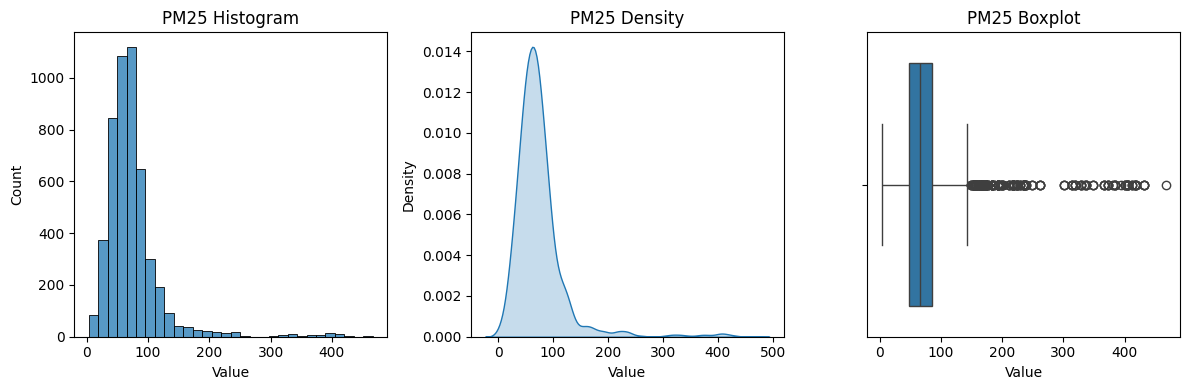

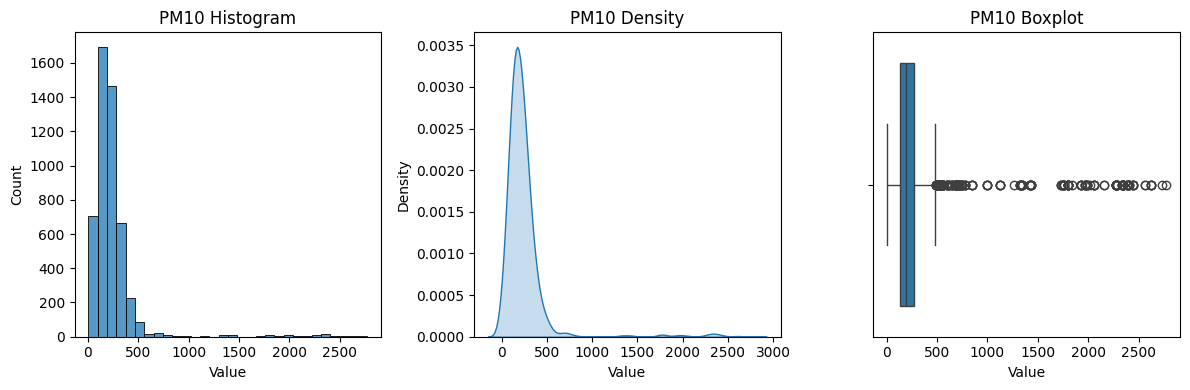

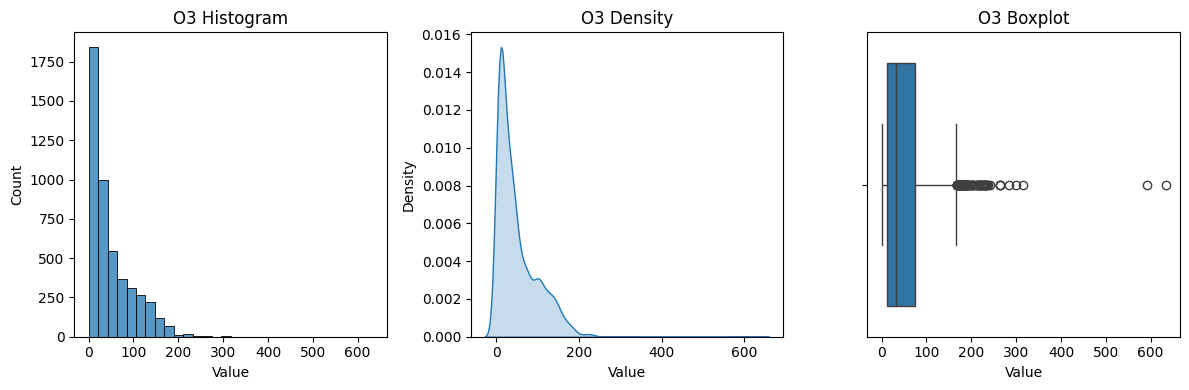

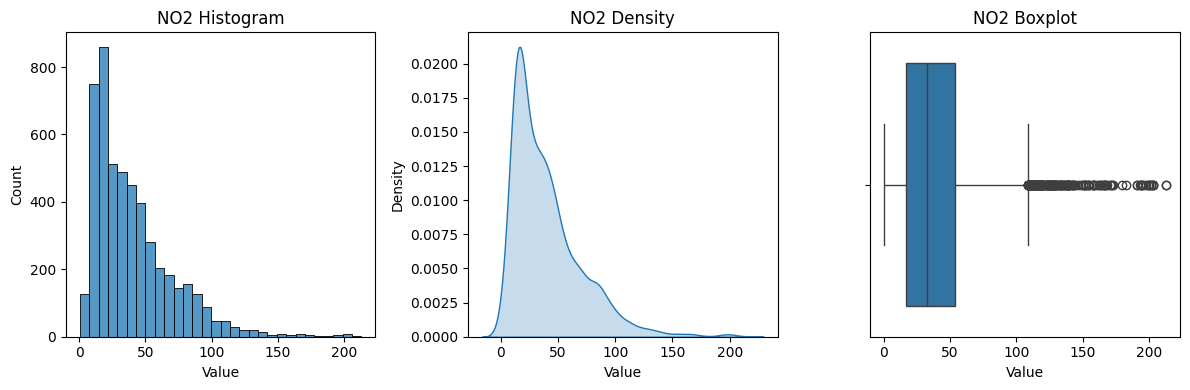

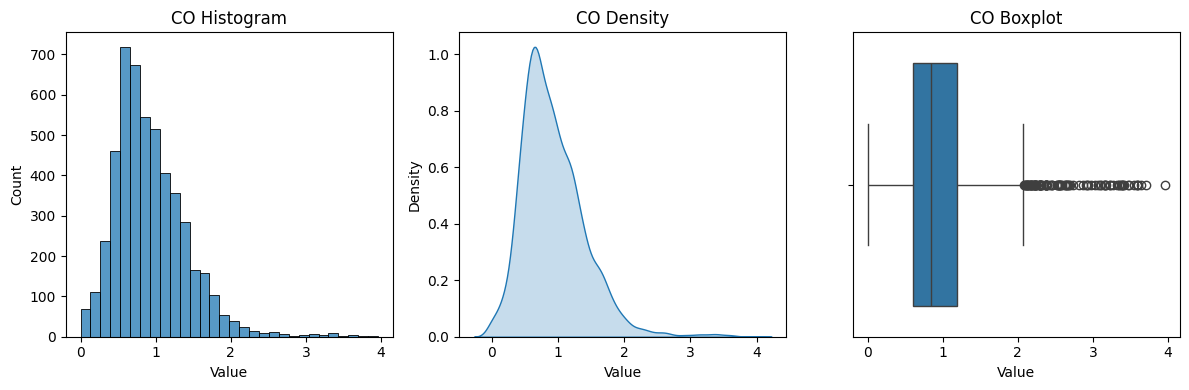

In [ ]:
for pollutant in key_pollutants:
    data = df[df['parameter'].str.lower() == pollutant]['value'].dropna()
    if data.empty:
        continue
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    sns.histplot(data, bins=30, kde=False)
    plt.title(f"{pollutant.upper()} Histogram")
    plt.xlabel('Value')
    plt.ylabel('Count')

    plt.subplot(1,3,2)
    sns.kdeplot(data, fill=True)
    plt.title(f"{pollutant.upper()} Density")
    plt.xlabel('Value')

    plt.subplot(1,3,3)
    sns.boxplot(x=data)
    plt.title(f"{pollutant.upper()} Boxplot")
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()


Outlier Detection

In [ ]:
for pollutant in key_pollutants:
    data = df[df['parameter'].str.lower() == pollutant]['value'].dropna()
    if data.empty:
        continue
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    print(f"{pollutant.upper()} has {len(outliers)} outliers out of {len(data)} records ({100*len(outliers)/len(data):.2f}%)")
    if not outliers.empty:
        print(f"Outlier value range: {outliers.min()} to {outliers.max()}")

PM25 has 233 outliers out of 4985 records (4.67%)
Outlier value range: 149.0 to 467.0
PM10 has 227 outliers out of 5000 records (4.54%)
Outlier value range: 486.0 to 2773.0
O3 has 115 outliers out of 4773 records (2.41%)
Outlier value range: 167.0 to 633.7
NO2 has 175 outliers out of 5000 records (3.50%)
Outlier value range: 108.6 to 212.9
CO has 103 outliers out of 4999 records (2.06%)
Outlier value range: 2.08 to 3.96


Remove Outliers

In [ ]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

def remove_outliers_iqr(df, parameter_col='parameter', value_col='value', pollutant='co'):
    subset = df[df[parameter_col].str.lower() == pollutant.lower()]
    Q1 = subset[value_col].quantile(0.25)
    Q3 = subset[value_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (subset[value_col] >= lower_bound) & (subset[value_col] <= upper_bound)
    print(f"{pollutant.upper()} - Removed {len(subset) - mask.sum()} outliers out of {len(subset)} records.")

    return pd.concat([df[df[parameter_col].str.lower() != pollutant.lower()], subset[mask]])

df_clean = remove_outliers_iqr(df, pollutant='co')

for pol in ['pm25', 'pm10', 'o3', 'no2', 'co']:
    df_clean = remove_outliers_iqr(df_clean, pollutant=pol)

CO - Removed 103 outliers out of 4999 records.
PM25 - Removed 233 outliers out of 4985 records.
PM10 - Removed 227 outliers out of 5000 records.
O3 - Removed 115 outliers out of 4773 records.
NO2 - Removed 175 outliers out of 5000 records.
CO - Removed 17 outliers out of 4896 records.


Compare Distributions Across Stations (Hotspot Analysis)

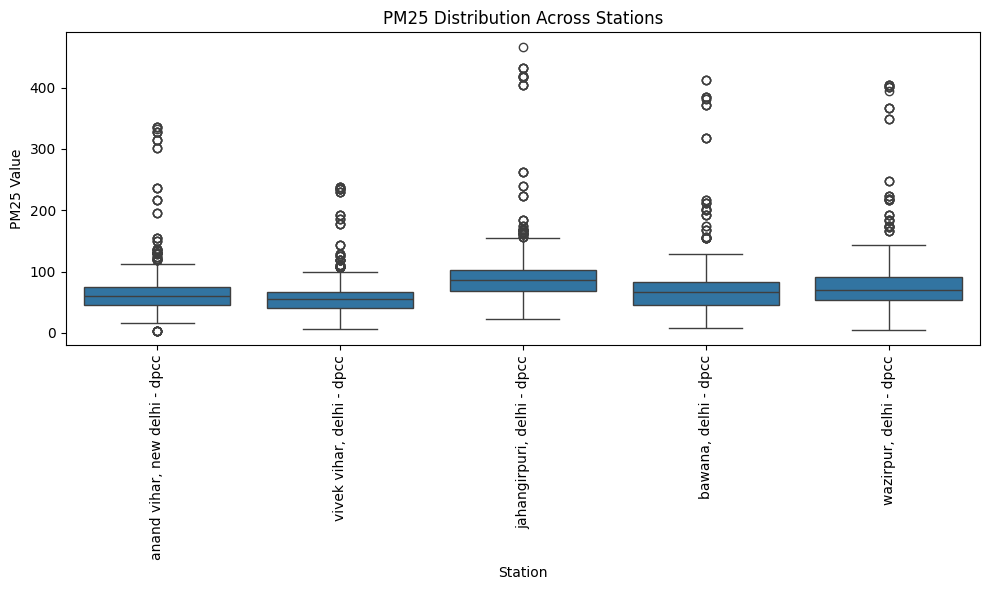

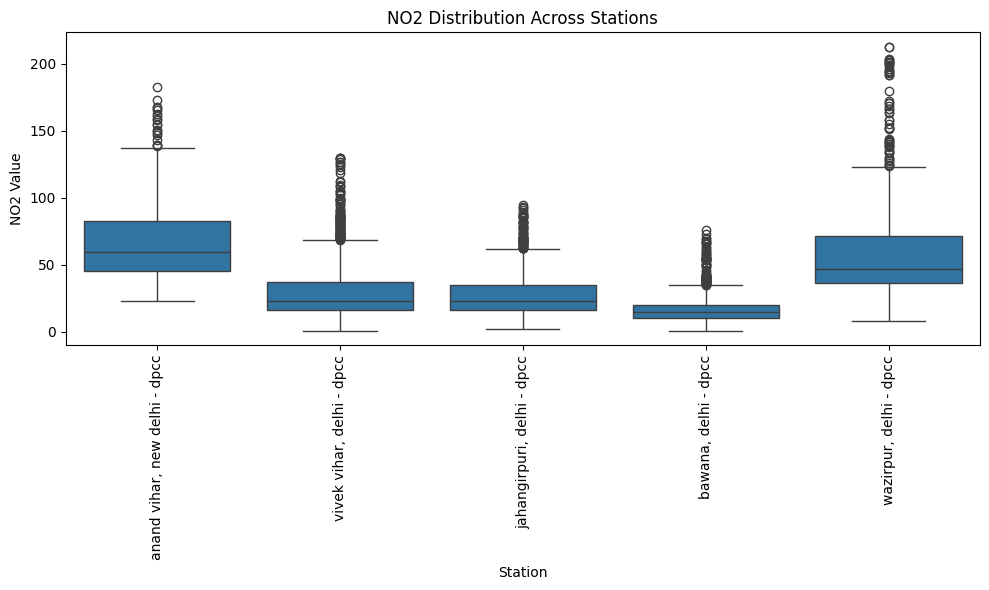

In [ ]:
for pollutant in ['pm25', 'no2']:
    subset = df[df['parameter'].str.lower() == pollutant]
    if subset.empty:
        continue
    plt.figure(figsize=(10,6))
    sns.boxplot(x='location_name', y='value', data=subset)
    plt.xticks(rotation=90)
    plt.title(f"{pollutant.upper()} Distribution Across Stations")
    plt.ylabel(f"{pollutant.upper()} Value")
    plt.xlabel("Station")
    plt.tight_layout()
    plt.show()

In [ ]:
for pollutant in ['pm25', 'no2']:
    subset = df[df['parameter'].str.lower() == pollutant]
    if subset.empty:
        continue
    means = subset.groupby('location_name')['value'].mean().sort_values(ascending=False)
    print(f"\n{pollutant.upper()} Mean by Station:")
    print(means.head(10))


PM25 Mean by Station:
location_name
jahangirpuri, delhi - dpcc       94.103553
wazirpur, delhi - dpcc           79.714000
bawana, delhi - dpcc             72.545000
anand vihar, new delhi - dpcc    66.876000
vivek vihar, delhi - dpcc        58.963000
Name: value, dtype: float64

NO2 Mean by Station:
location_name
anand vihar, new delhi - dpcc    65.8862
wazirpur, delhi - dpcc           59.2097
vivek vihar, delhi - dpcc        31.3694
jahangirpuri, delhi - dpcc       28.4125
bawana, delhi - dpcc             17.1802
Name: value, dtype: float64


**Temporal Analysis**

Parse the Data

Parse datetime columns and ensure timezone-awareness

In [ ]:
df['datetimeLocal'] = pd.to_datetime(df['datetimeLocal'], errors='coerce')
df['datetimeUtc'] = pd.to_datetime(df['datetimeUtc'], utc=True, errors='coerce')

pollutant = 'co'
df_pollutant = df[df['parameter'].str.lower() == pollutant].copy()

df_pollutant = df_pollutant.sort_values('datetimeLocal')

Plot Time Series for Each Major Pollutant

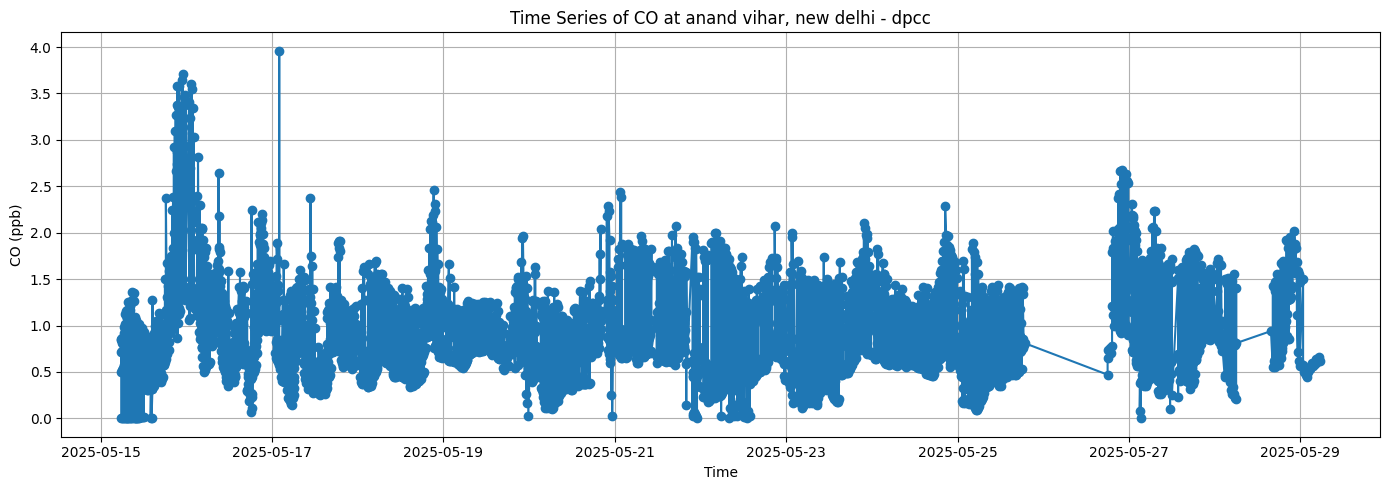

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df_pollutant['datetimeLocal'], df_pollutant['value'], marker='o', linestyle='-')
plt.title(f"Time Series of {pollutant.upper()} at {df_pollutant['location_name'].iloc[0]}")
plt.xlabel('Time')
plt.ylabel(f"{pollutant.upper()} ({df_pollutant['unit'].iloc[0]})")
plt.grid(True)
plt.tight_layout()
plt.show()

Time Series Decomposition (Trend, Seasonality, Residual)

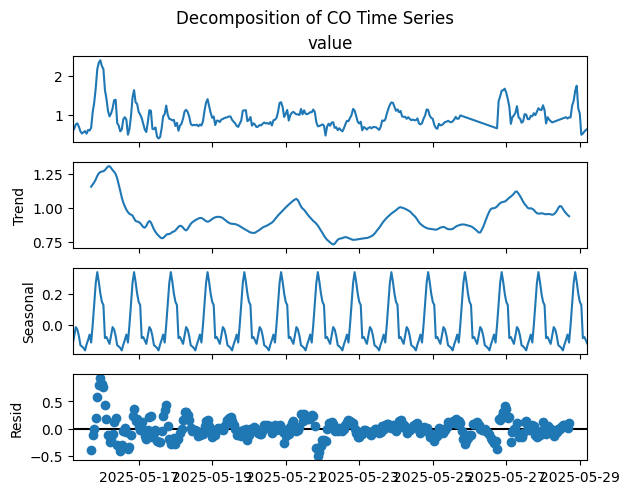

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_pollutant.set_index('datetimeLocal')['value'].resample('h').mean()

ts = ts.interpolate()

result = seasonal_decompose(ts, model='additive', period=24)

result.plot()
plt.suptitle(f"Decomposition of {pollutant.upper()} Time Series", y=1.02)
plt.show()

Diurnal and Weekly Patterns

Add Hour and Day-of-Week Columns

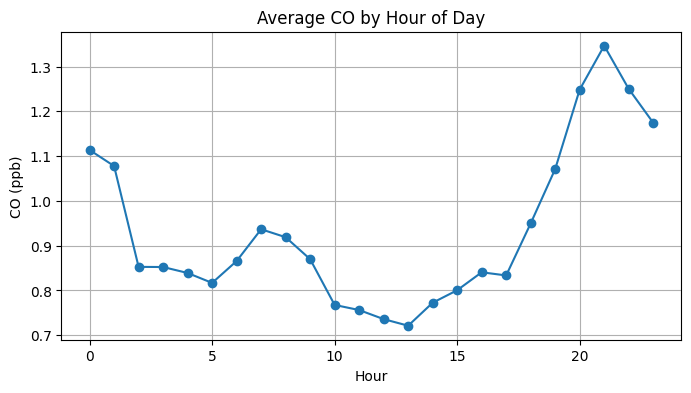

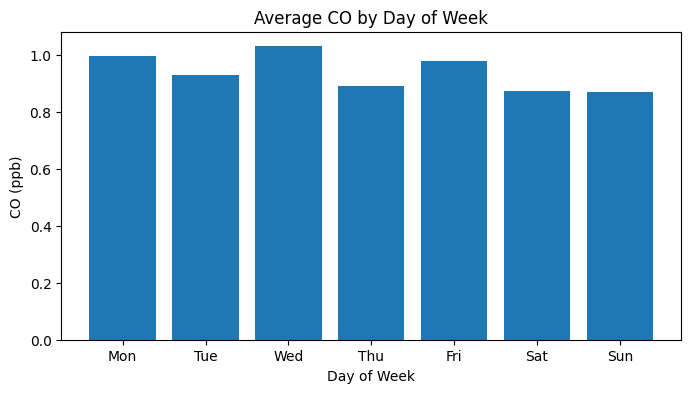

In [ ]:
df_pollutant['hour'] = df_pollutant['datetimeLocal'].dt.hour
df_pollutant['dayofweek'] = df_pollutant['datetimeLocal'].dt.dayofweek  # 0=Monday

# Diurnal pattern
hourly_avg = df_pollutant.groupby('hour')['value'].mean()

plt.figure(figsize=(8,4))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title(f"Average {pollutant.upper()} by Hour of Day")
plt.xlabel('Hour')
plt.ylabel(f"{pollutant.upper()} ({df_pollutant['unit'].iloc[0]})")
plt.grid(True)
plt.show()

# Weekly pattern
dow_avg = df_pollutant.groupby('dayofweek')['value'].mean()
plt.figure(figsize=(8,4))
plt.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], dow_avg.values)
plt.title(f"Average {pollutant.upper()} by Day of Week")
plt.xlabel('Day of Week')
plt.ylabel(f"{pollutant.upper()} ({df_pollutant['unit'].iloc[0]})")
plt.show()


Event-Based and Lag Analysis

Weekdays vs. Weekends

In [ ]:
df_pollutant['is_weekend'] = df_pollutant['dayofweek'] >= 5
weekend_avg = df_pollutant.groupby('is_weekend')['value'].mean()
print(f"Weekday Average: {weekend_avg[False]:.2f}, Weekend Average: {weekend_avg[True]:.2f}")

Weekday Average: 0.96, Weekend Average: 0.87


Visualize Weekday vs. Weekend Patterns

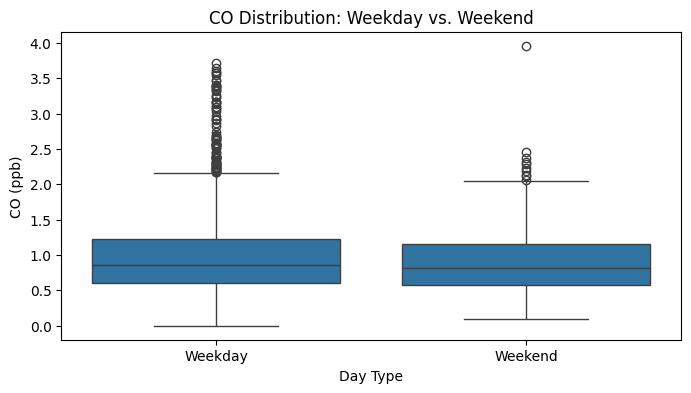

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='is_weekend', y='value', data=df_pollutant)
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.title(f"{pollutant.upper()} Distribution: Weekday vs. Weekend")
plt.xlabel('Day Type')
plt.ylabel(f"{pollutant.upper()} ({df_pollutant['unit'].iloc[0]})")
plt.show()

Lag Effect

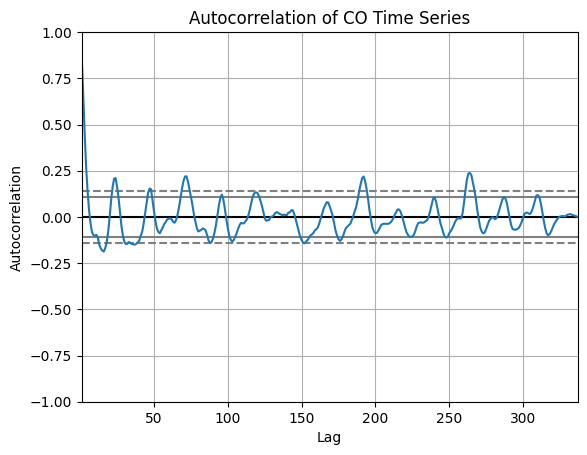

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts)
plt.title(f"Autocorrelation of {pollutant.upper()} Time Series")
plt.show()

Detect and Remove Outliers for Temperature and Relative Humidity

In [ ]:
def remove_outliers_iqr(df, parameter_name):

    mask = df['parameter'].str.lower() == parameter_name.lower()
    data = df[mask]
    if data.empty:
        print(f"No data for {parameter_name}")
        return df

    Q1 = data['value'].quantile(0.25)
    Q3 = data['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (data['value'] < lower) | (data['value'] > upper)
    n_outliers = outlier_mask.sum()
    print(f"{parameter_name}: Removing {n_outliers} outliers out of {len(data)} records.")

    # Remove outliers
    df_clean = pd.concat([
        df[~mask],
        data[~outlier_mask]
    ])
    return df_clean


df = remove_outliers_iqr(df, 'temperature')

df = remove_outliers_iqr(df, 'relativehumidity')


temperature: Removing 36 outliers out of 5000 records.
relativehumidity: Removing 194 outliers out of 5000 records.


**Bivariate and Multivariate Analysis**

Check Results

In [ ]:
for param in ['temperature', 'relativehumidity']:
    vals = df[df['parameter'].str.lower() == param]['value']
    print(f"{param} - min: {vals.min()}, max: {vals.max()}")

temperature - min: 23.4, max: 40.1
relativehumidity - min: 29.0, max: 82.0


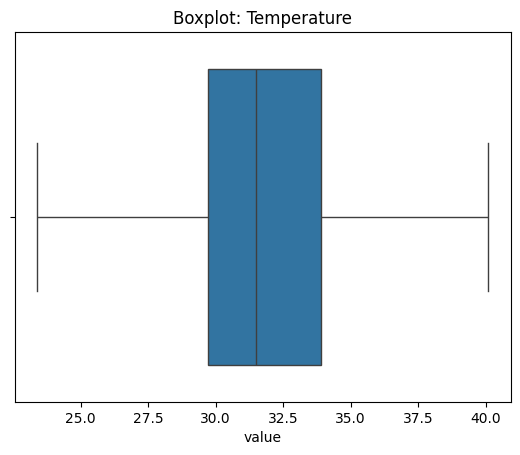

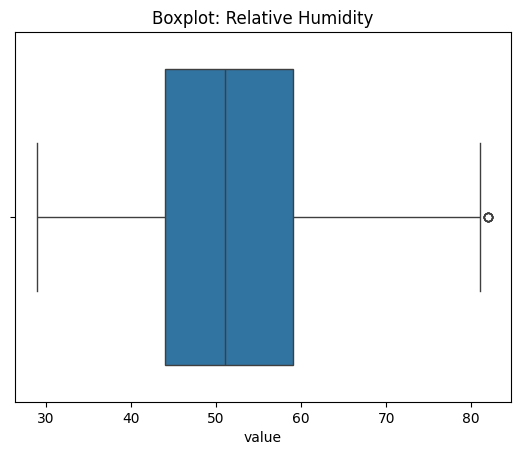

In [ ]:
# Assuming you have the cleaned DataFrame as 'df'
sns.boxplot(x=df[df['parameter']=='temperature']['value'])
plt.title('Boxplot: Temperature')
plt.show()

sns.boxplot(x=df[df['parameter']=='relativehumidity']['value'])
plt.title('Boxplot: Relative Humidity')
plt.show()

Reshape Data: Pivot to Wide Format

In [ ]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

df_wide = df.pivot_table(
    index=['datetimeLocal', 'location_id', 'location_name', 'latitude', 'longitude'],
    columns='parameter',
    values='value'
).reset_index()

print(df_wide.columns)

Index(['datetimeLocal', 'location_id', 'location_name', 'latitude',
       'longitude', 'co', 'no', 'no2', 'o3', 'pm10', 'pm25',
       'relativehumidity', 'so2', 'temperature'],
      dtype='object', name='parameter')


Correlation Matrix (Pollutants & Meteorological Factors)

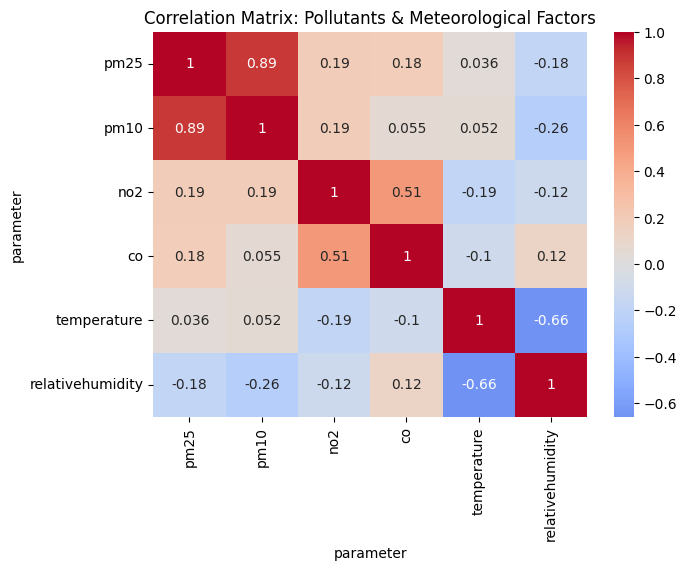

In [ ]:
cols = [col for col in ['pm25', 'pm10', 'no2', 'co', 'temperature', 'relativehumidity'] if col in df_wide.columns]

corr = df_wide[cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Pollutants & Meteorological Factors')
plt.show()

Scatter Plots: Pollutant vs. Meteorological Factor

PM2.5 vs Temperature

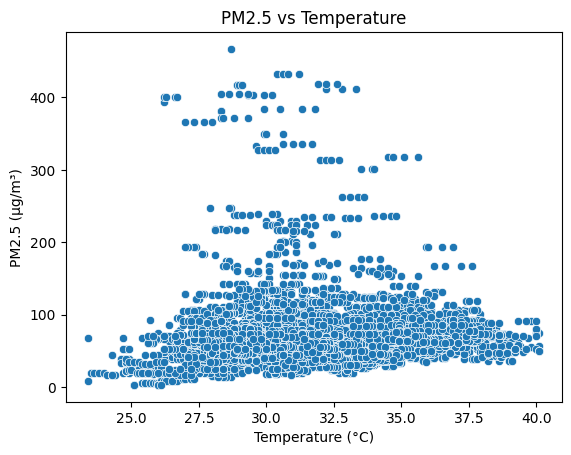

In [ ]:
if 'pm25' in df_wide and 'temperature' in df_wide:
    sns.scatterplot(x='temperature', y='pm25', data=df_wide)
    plt.title('PM2.5 vs Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.show()

NO2 vs Relative Humidity

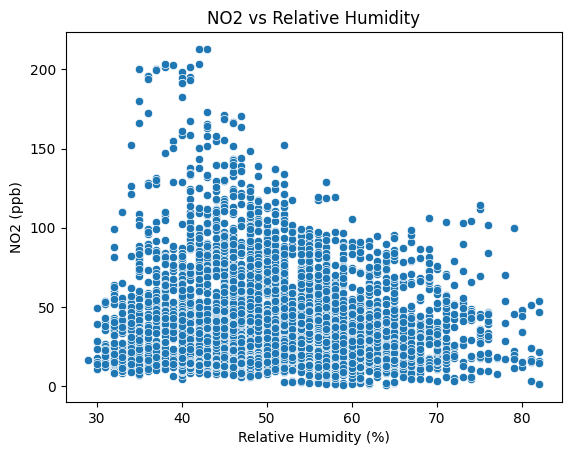

In [ ]:
if 'no2' in df_wide and 'relativehumidity' in df_wide:
    sns.scatterplot(x='relativehumidity', y='no2', data=df_wide)
    plt.title('NO2 vs Relative Humidity')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('NO2 (ppb)')
    plt.show()

Multivariate Visualization: Scatter Colored by Temperature

PM2.5 vs NO2, colored by Temperature

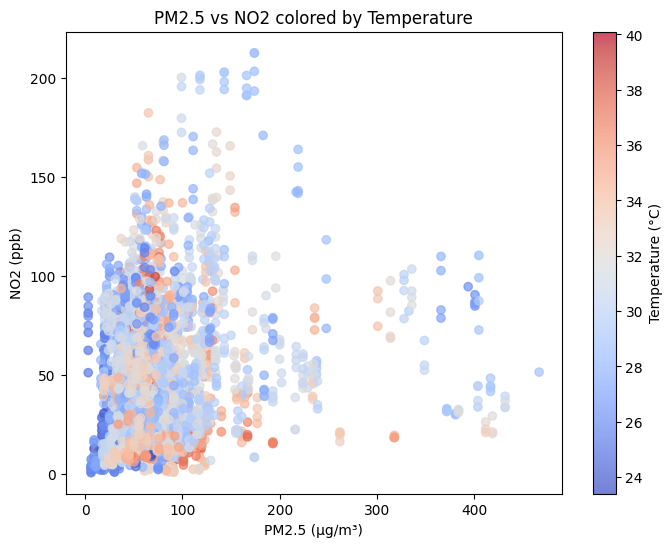

In [ ]:
if all(col in df_wide for col in ['pm25', 'no2', 'temperature']):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(df_wide['pm25'], df_wide['no2'], c=df_wide['temperature'], cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter, label='Temperature (°C)')
    plt.xlabel('PM2.5 (µg/m³)')
    plt.ylabel('NO2 (ppb)')
    plt.title('PM2.5 vs NO2 colored by Temperature')
    plt.show()

Pair Plot for All Key Variables

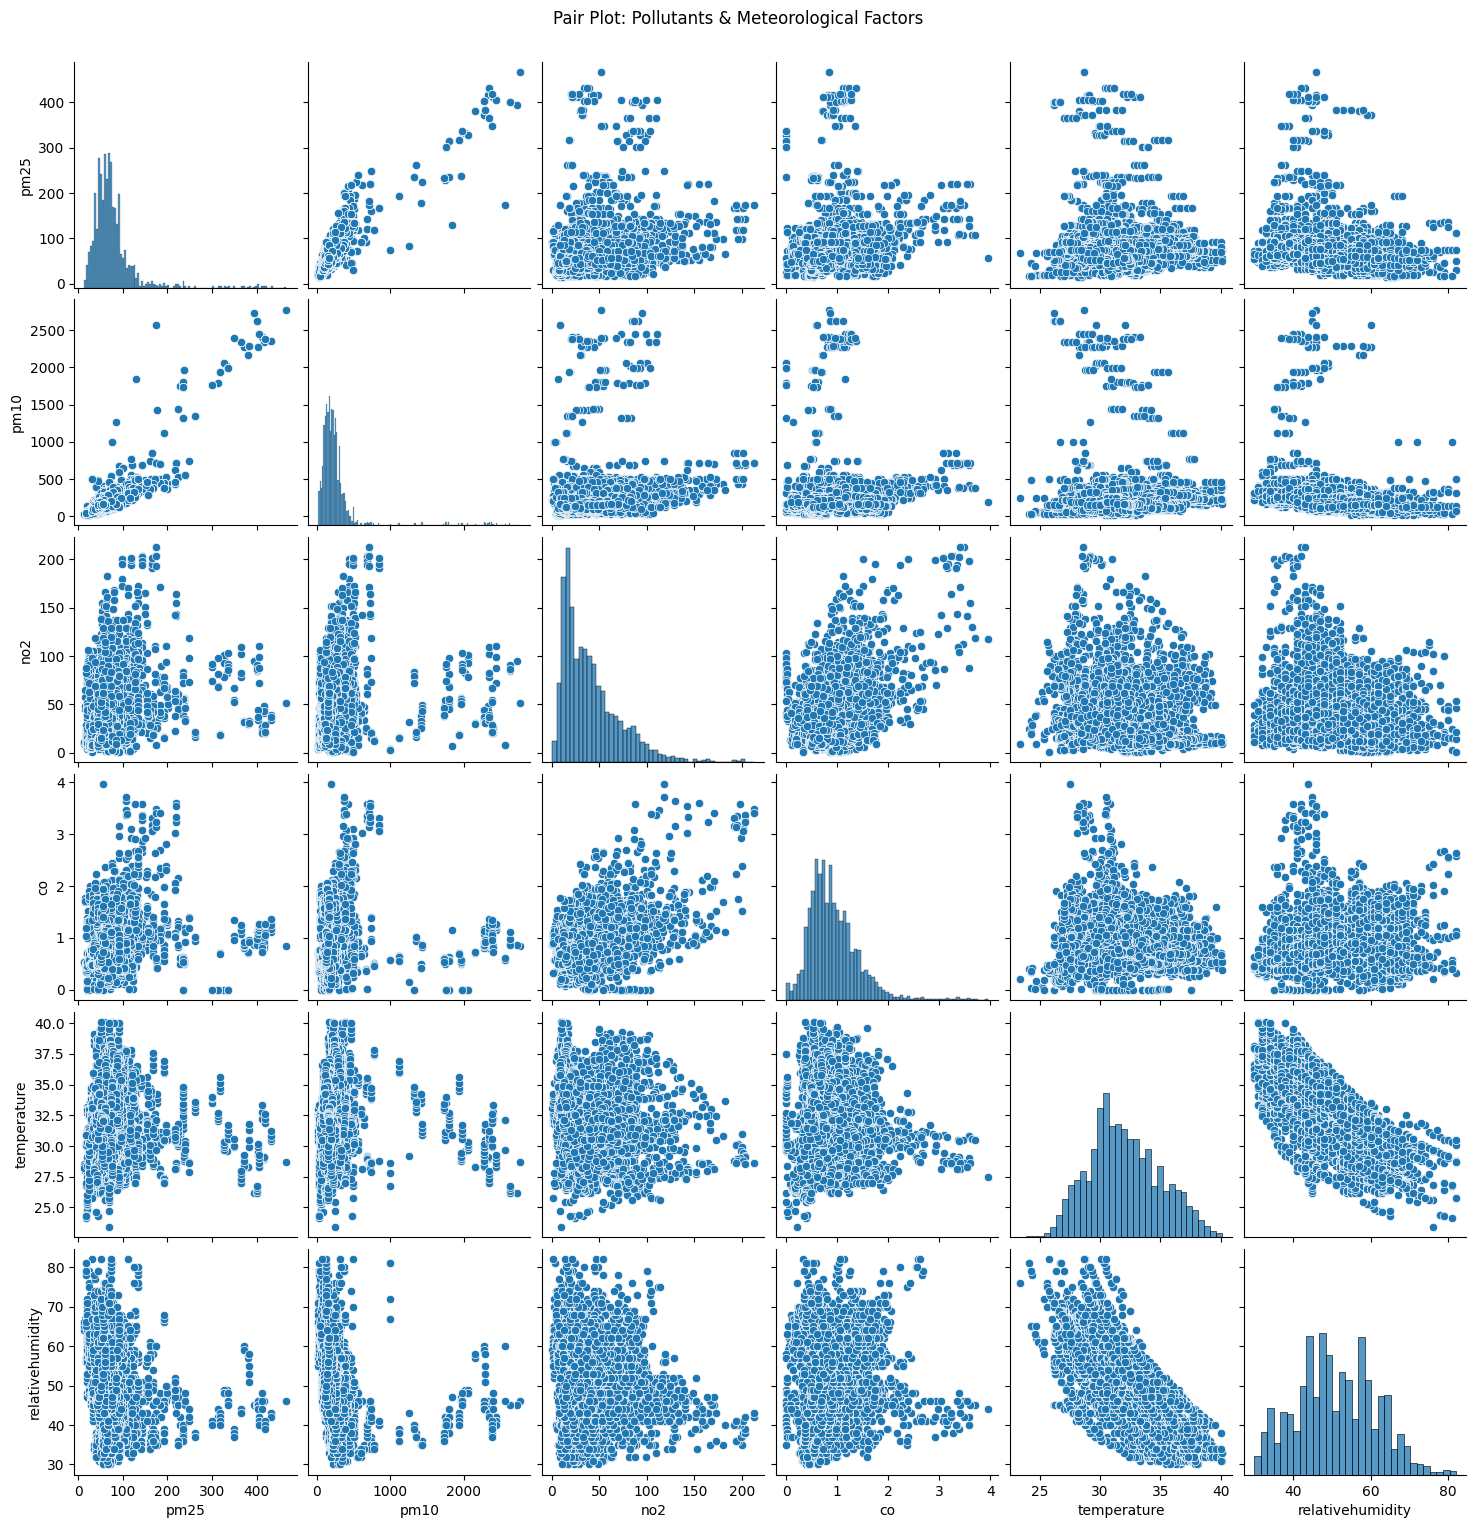

In [ ]:
from seaborn import pairplot

pairplot_cols = [col for col in ['pm25', 'pm10', 'no2', 'co', 'temperature', 'relativehumidity'] if col in df_wide.columns]
sns.pairplot(df_wide[pairplot_cols].dropna())
plt.suptitle('Pair Plot: Pollutants & Meteorological Factors', y=1.02)
plt.show()

Conditional Distribution: PM2.5 at Low vs High Temperature

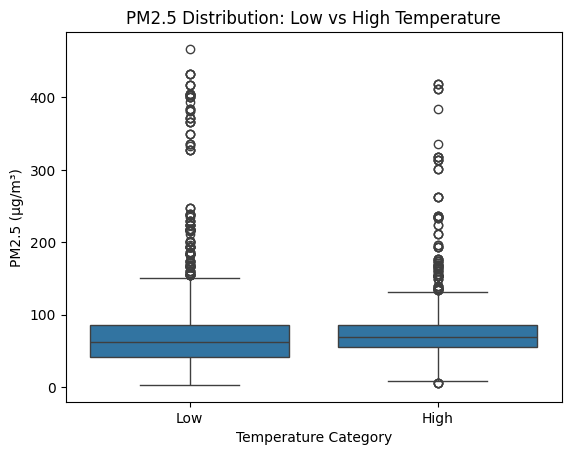

In [ ]:
if 'pm25' in df_wide and 'temperature' in df_wide:
    temp_median = df_wide['temperature'].median()
    df_wide['temp_category'] = ['Low' if t < temp_median else 'High' for t in df_wide['temperature']]
    sns.boxplot(x='temp_category', y='pm25', data=df_wide)
    plt.title('PM2.5 Distribution: Low vs High Temperature')
    plt.xlabel('Temperature Category')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.show()

**Spatial Analysis**

Calculate Average Pollution by Station

In [ ]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

pollutant = 'co'
df_pollutant = df[df['parameter'].str.lower() == pollutant]

station_avg = (
    df_pollutant.groupby(['location_id', 'location_name', 'latitude', 'longitude'])
    ['value'].mean().reset_index()
)

Basic Map: Scatter Plot of Stations Colored by Pollution Level

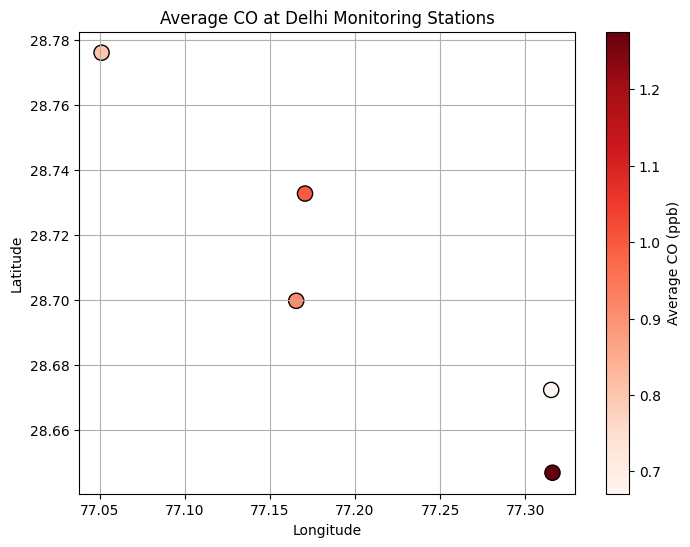

In [ ]:
plt.figure(figsize=(8,6))
sc = plt.scatter(
    station_avg['longitude'], station_avg['latitude'],
    c=station_avg['value'], cmap='Reds', s=120, edgecolor='k'
)
plt.colorbar(sc, label=f'Average {pollutant.upper()} (ppb)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Average {pollutant.upper()} at Delhi Monitoring Stations')
plt.grid(True)
plt.show()

 Interactive Map with Folium

In [ ]:
import folium

m = folium.Map(location=[28.61, 77.23], zoom_start=11)

for _, row in station_avg.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"{row['location_name']}<br>Avg {pollutant.upper()}: {row['value']:.2f} ppb"
    ).add_to(m)

m.save('delhi_air_quality_map.html')

Compare Urban Zones (Manual Classification)

In [ ]:
zone_map = {
    'Anand Vihar, New Delhi - DPCC': 'Traffic',
}
station_avg['zone_type'] = station_avg['location_name'].map(zone_map)

zone_means = station_avg.groupby('zone_type')['value'].mean()
print(zone_means)

Series([], Name: value, dtype: float64)


Spatial Variation by Time of Day (e.g., Morning vs. Midday)

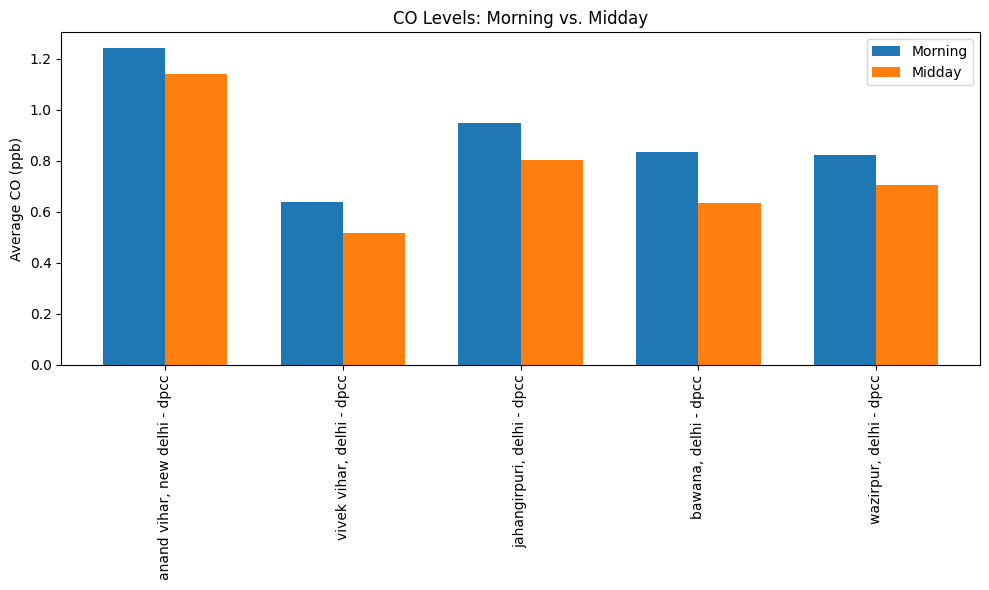

In [ ]:
df_pollutant = df_pollutant.copy()

df_pollutant['datetimeLocal'] = pd.to_datetime(df_pollutant['datetimeLocal'])
df_pollutant['hour'] = df_pollutant['datetimeLocal'].dt.hour

morning = df_pollutant[df_pollutant['hour'].between(6,9)]
midday = df_pollutant[df_pollutant['hour'].between(12,15)]

morning_avg = morning.groupby(['location_id', 'location_name', 'latitude', 'longitude'])['value'].mean().reset_index()
midday_avg = midday.groupby(['location_id', 'location_name', 'latitude', 'longitude'])['value'].mean().reset_index()

import numpy as np
labels = morning_avg['location_name']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, morning_avg['value'], width, label='Morning')
ax.bar(x + width/2, midday_avg['value'], width, label='Midday')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel(f'Average {pollutant.upper()} (ppb)')
ax.set_title(f'{pollutant.upper()} Levels: Morning vs. Midday')
ax.legend()
plt.tight_layout()
plt.show()

**Anomaly Detection**

Load and Prepare Data

In [ ]:
# Ensure datetime is parsed correctly
df['datetimeLocal'] = pd.to_datetime(df['datetimeLocal'])

# Sort by datetime for time series analysis
df = df.sort_values('datetimeLocal')

Simple Statistical Rule-Based Anomaly Detection

In [ ]:
# Focus on a single station and pollutant for clarity
df_station = df[(df['location_name'] == "Anand Vihar, New Delhi - DPCC") & (df['parameter'] == 'co')].copy()
df_station = df_station.sort_values('datetimeLocal')

# Rolling mean and std
window = 6  # 6 samples ~3 hours if data is every 30 minutes
df_station['rolling_mean'] = df_station['value'].rolling(window, center=True).mean()
df_station['rolling_std'] = df_station['value'].rolling(window, center=True).std()

# Anomaly detection: flag points >3 std from rolling mean
threshold = 3
df_station['anomaly'] = np.abs(df_station['value'] - df_station['rolling_mean']) > (threshold * df_station['rolling_std'])

Visualize Anomalies

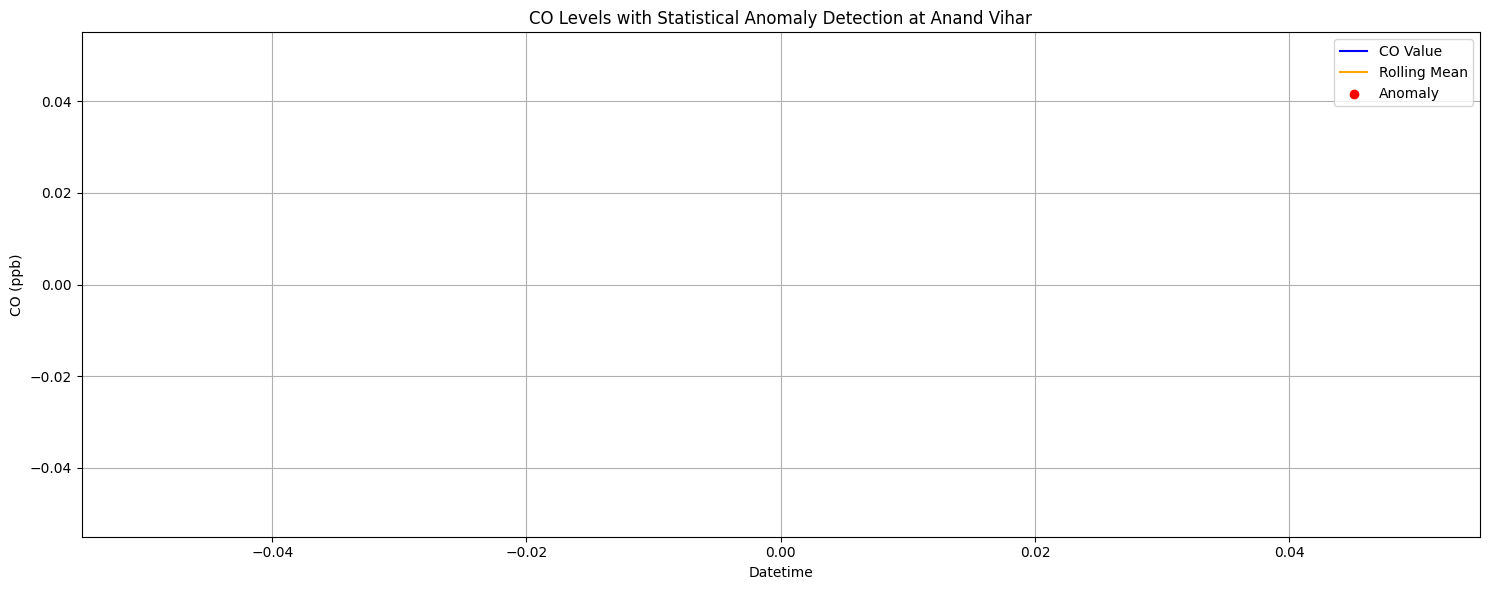

In [ ]:
df_station = df[(df['location_name'] == "Anand Vihar, New Delhi - DPCC") & (df['parameter'].str.lower() == 'co')].copy()

df_station['datetimeLocal'] = pd.to_datetime(df_station['datetimeLocal'], errors='coerce')
df_station = df_station.dropna(subset=['datetimeLocal'])
df_station = df_station.sort_values('datetimeLocal')

window = 6
df_station['rolling_mean'] = df_station['value'].rolling(window, center=True).mean()
df_station['rolling_std'] = df_station['value'].rolling(window, center=True).std()

threshold = 3
df_station['anomaly'] = np.abs(df_station['value'] - df_station['rolling_mean']) > (threshold * df_station['rolling_std'])

plt.figure(figsize=(15,6))
plt.plot(df_station['datetimeLocal'], df_station['value'], label='CO Value', color='blue')
plt.plot(df_station['datetimeLocal'], df_station['rolling_mean'], label='Rolling Mean', color='orange')
plt.scatter(
    df_station.loc[df_station['anomaly'], 'datetimeLocal'],
    df_station.loc[df_station['anomaly'], 'value'],
    color='red', label='Anomaly', zorder=5
)
plt.xlabel('Datetime')
plt.ylabel('CO (ppb)')
plt.title('CO Levels with Statistical Anomaly Detection at Anand Vihar')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
print(df_station['value'].describe())
print(df_station['value'].unique())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64
[]


In [ ]:
valid_data = df.dropna(subset=['value'])
summary = valid_data.groupby(['location_name', 'parameter'])['value'].count().reset_index()
summary = summary.sort_values(by='value', ascending=False)
print(summary.head(10))

                    location_name    parameter  value
0   anand vihar, new delhi - dpcc           co   1000
1   anand vihar, new delhi - dpcc           no   1000
2   anand vihar, new delhi - dpcc          no2   1000
4   anand vihar, new delhi - dpcc         pm10   1000
5   anand vihar, new delhi - dpcc         pm25   1000
11           bawana, delhi - dpcc          no2   1000
7   anand vihar, new delhi - dpcc          so2   1000
8   anand vihar, new delhi - dpcc  temperature   1000
9            bawana, delhi - dpcc           co   1000
12           bawana, delhi - dpcc           o3   1000


In [ ]:
for param in ['co', 'no', 'no2', 'pm10', 'pm25', 'so2', 'temperature']:
    subset = df[(df['location_name'].str.lower() == 'anand vihar, new delhi - dpcc') & (df['parameter'].str.lower() == param)]
    print(f"\n{param.upper()} - {subset['value'].describe()}")


CO - count    1000.000000
mean        1.275288
std         0.393684
min         0.000000
25%         1.060000
50%         1.270000
75%         1.510000
max         2.820000
Name: value, dtype: float64

NO - count    1000.000000
mean       29.082600
std        50.070219
min         1.600000
25%         9.600000
50%        13.000000
75%        21.125000
max       423.600000
Name: value, dtype: float64

NO2 - count    1000.000000
mean       65.886200
std        26.795812
min        22.600000
25%        45.200000
50%        59.600000
75%        82.400000
max       182.500000
Name: value, dtype: float64

PM10 - count    1000.000000
mean      225.245000
std       252.847177
min        11.000000
25%       121.000000
50%       180.000000
75%       242.250000
max      2061.000000
Name: value, dtype: float64

PM25 - count    1000.00000
mean       66.87600
std        43.89448
min         3.00000
25%        46.00000
50%        60.00000
75%        74.00000
max       336.00000
Name: value, dtype: f

In [ ]:
df_station = df[
    (df['location_name'].str.lower() == 'anand vihar, new delhi - dpcc') &
    (df['parameter'].str.lower() == 'pm25')
].copy()

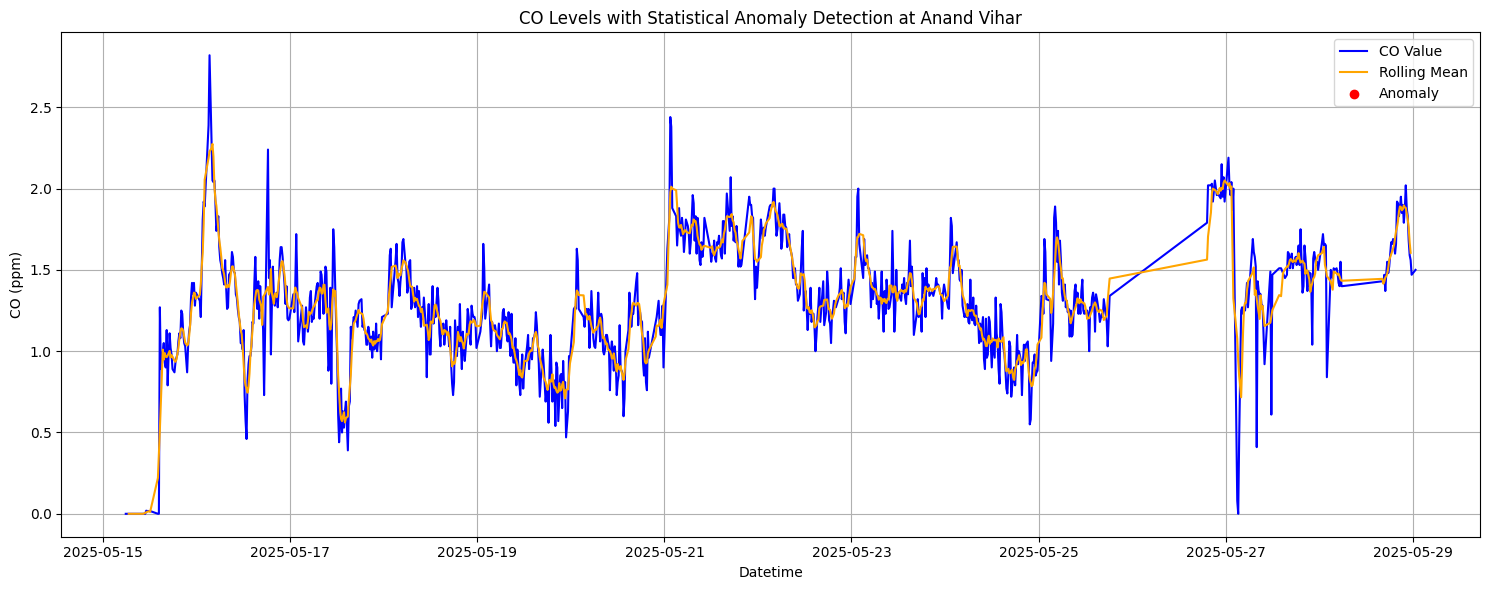

In [ ]:
# Filter the data: CO at Anand Vihar
df_station = df[
    (df['location_name'].str.lower() == 'anand vihar, new delhi - dpcc') &
    (df['parameter'].str.lower() == 'co')
].copy()

# Parse dates
df_station['datetimeLocal'] = pd.to_datetime(df_station['datetimeLocal'], errors='coerce')
df_station = df_station.dropna(subset=['datetimeLocal', 'value'])  # drop rows with NaT or NaN
df_station = df_station.sort_values('datetimeLocal')

# Rolling mean and std for anomaly detection
window = 6
df_station['rolling_mean'] = df_station['value'].rolling(window, center=True).mean()
df_station['rolling_std'] = df_station['value'].rolling(window, center=True).std()

# Flag anomalies: values beyond 3 standard deviations from rolling mean
threshold = 3
df_station['anomaly'] = np.abs(df_station['value'] - df_station['rolling_mean']) > (threshold * df_station['rolling_std'])

# Plot
plt.figure(figsize=(15,6))
plt.plot(df_station['datetimeLocal'], df_station['value'], label='CO Value', color='blue')
plt.plot(df_station['datetimeLocal'], df_station['rolling_mean'], label='Rolling Mean', color='orange')
plt.scatter(
    df_station.loc[df_station['anomaly'], 'datetimeLocal'],
    df_station.loc[df_station['anomaly'], 'value'],
    color='red', label='Anomaly', zorder=5
)
plt.xlabel('Datetime')
plt.ylabel('CO (ppm)')
plt.title('CO Levels with Statistical Anomaly Detection at Anand Vihar')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()